# WRMF

**Objectives:**
1. Compute the implicit ratings playlist-song matrix
2. Factorise the matrix and output playlist and song embeddings
3. Find the 20,000 most used songs for each playlist.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import implicit

In [57]:
df = pd.read_csv("cleaned_data_0.2.csv", index_col=[0])

In [38]:
df.head()

,source,user_id,track_name,artist_name,playlist_id,tags,playlist_name,spotify_id,album,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,vagalume,sitevagalume,Eraser,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7oolFzHipTMg2nL7shhdz2,÷ (Deluxe),64.0,0.640,0.812,-5.647,0.0834,0.0860,0.000000,0.0509,0.914,86.013
1,vagalume,sitevagalume,Castle On The Hill,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,6PCUP3dWmTjcTtXY02oFdT,÷ (Deluxe),78.0,0.461,0.834,-4.868,0.0989,0.0232,0.000011,0.1400,0.471,135.007
2,vagalume,sitevagalume,Dive,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,51ChrwmUPDJvedPQnIU8Ls,÷ (Deluxe),75.0,0.761,0.386,-6.158,0.0399,0.3550,0.000000,0.0953,0.526,134.943
3,vagalume,sitevagalume,Shape Of You,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,7qiZfU4dY1lWllzX7mPBI3,÷ (Deluxe),85.0,0.825,0.652,-3.183,0.0802,0.5810,0.000000,0.0931,0.931,95.977
4,vagalume,sitevagalume,Perfect,Ed Sheeran,6736120,"pop,pop/rock,rock",Ed Sheeran - Divide,0tgVpDi06FyKpA1z0VMD4v,÷ (Deluxe),86.0,0.599,0.448,-6.312,0.0232,0.1630,0.000000,0.1060,0.168,95.050


In [14]:
df.describe()

,playlist_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,5.605800e+05,560580.000000,560580.000000,560580.000000,560580.000000,560580.000000,560580.000000,560580.000000,560580.000000,560580.000000,560580.000000
mean,4.883720e+06,44.834045,0.585467,0.650172,-7.650535,0.078989,0.291727,0.063936,0.232787,0.531227,122.459596
std,1.582749e+06,22.334717,0.158456,0.223298,4.132012,0.088246,0.296057,0.205016,0.216726,0.248684,28.813805
min,1.870000e+02,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.086943e+06,28.000000,0.483000,0.500000,-9.362000,0.033900,0.029600,0.000000,0.098600,0.334000,99.989000
50%,5.340961e+06,47.000000,0.595000,0.685000,-6.671000,0.045600,0.181000,0.000003,0.137000,0.535000,122.668000
75%,5.593525e+06,63.000000,0.698000,0.832000,-4.877000,0.079100,0.512000,0.000711,0.296000,0.737000,139.994000
max,6.774895e+06,100.000000,0.988000,1.000000,3.776000,0.966000,0.996000,1.000000,1.000000,1.000000,247.972000


## Implicit Ratings Matrix

We now need to create a songs-playlist matrix, $R$.

$R_{ij}$ is 1 if song $i$ is in playlist $j$ and 0 otherwise.

In [53]:
# 1-2 line solution but resulting matrix is very sparse and wastes a LOT of memory (~100MB becomes ~1GB)

# assert np.isfinite(df.popularity).all()
# songs_playlist = df.pivot_table(index="spotify_id", columns="playlist_id",
#                                 aggfunc=lambda x: 1, fill_value=0, values="popularity")

First let us calculate the sparsity of the dataset as it is.

In [130]:
def sparsity(df):
    return float(df.shape[0])*100/float(len(df.spotify_id.unique()) * len(df.playlist_id.unique()))

print(f"Sparsity: {sparsity(df):.5f}%")

Sparsity: 0.05032%


A good sparsity here would be approx. 0.1%.

Let us remove some very short playlists to see whether our sparsity improves.

Note - perhaps the better strategy to improve sparsity would be to remove the most novel (least popular) songs. However, this may introduce bias.

In [141]:
def plot_value_occurences(column, df=df):
    value_counts = pd.value_counts(df[column])

    plt.figure(figsize=(12,10))

    plt.xlabel(column)
    plt.ylabel(f"{column} Occurences")

    plt.plot(value_counts.values, marker="x")
    plt.show()

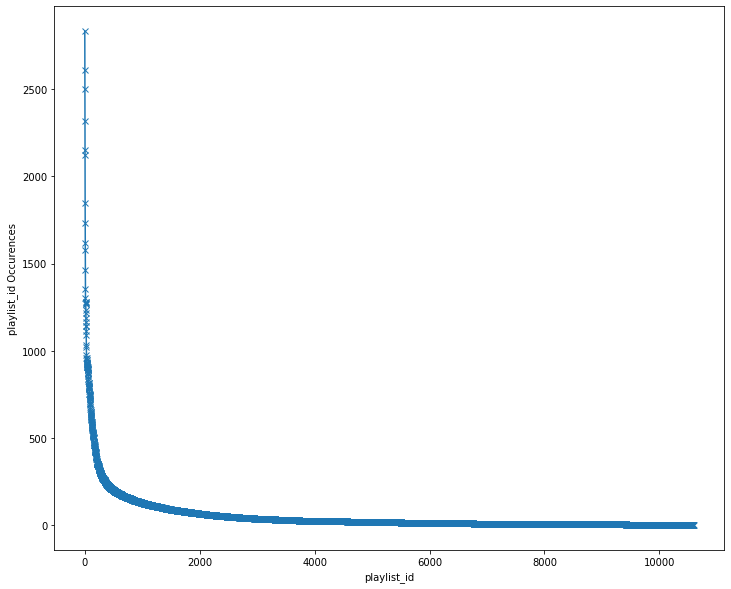

In [142]:
plot_value_occurences("playlist_id")

In [143]:
def cold_start_indxs(df, song_threshold=2, return_playlist=False, reverse=False):
    """
    Returns the *index* for all playlists which do not have at least the treshold number of songs.
    """
    value_counts = pd.value_counts(df.playlist_id)
    if reverse:
        playlists = value_counts[value_counts>song_threshold].index.values
    else:
        playlists = value_counts[value_counts<song_threshold].index.values
    
    if return_playlist:
        return df[df.playlist_id.isin(playlists)].index, playlists
    else:
        return df[df.playlist_id.isin(playlists)].index

In [155]:
short_playlists = cold_start_indxs(df, song_threshold=2)

print(f"% of records from playlists below threshold length: {len(short_playlists)*100/len(df):.2f}%")

% of records from playlists below threshold length: 0.09%


In [157]:
new_df = df.drop(short_playlists, axis=0)

print(f"% of playlists retained: {len(new_df.playlist_id.unique())*100/len(df.playlist_id.unique()):.2f}%")
print(f"Sparsity: {sparsity(new_df):.5f}%")

% of playlists retained: 95.44%
Sparsity: 0.05269%


We can see that we have improved our sparsity by 0.006% but have also lost 0.5% of all records and, more importantly, 5% of all playlists. This is likely not a good tradeoff in the long run.

Let us now explore what would happen if we removed the longest playlists. This should not drastically reduce the number of playlists in our dataset but may have a significant impact on sparsity depending on how novel the songs in these very long playlists are.

In [164]:
short_playlists = cold_start_indxs(df, song_threshold=1000, reverse=True)

print(f"% of records from playlists above threshold length: {len(short_playlists)*100/len(df):.2f}%")

new_df = df.drop(short_playlists, axis=0)

print(f"% of playlists retained: {len(new_df.playlist_id.unique())*100/len(df.playlist_id.unique()):.2f}%")
print(f"Sparsity: {sparsity(new_df):.5f}%")

% of records from playlists above threshold length: 7.70%
% of playlists retained: 99.74%
Sparsity: 0.04907%


From the above we can see that dropping the longest playlists allows us to retail near 100% of all playlists while lowering the number of records by 7%.

However, the sparsity of this new dataset actually decreases. This suggests that many of the songs in these very long playlists are very popular (as is to be expected) and thus were not significantly contributing to the low sparsity.

It seems then that neither removing the longest playlists nor the shortest seem like good options.

For now, let us move forward with the original dataset (with a sparsity of 0.050%) and see what recall we can achieve with our WRMF recommendations. If this is sufficiently high $(\gtrapprox{60}\%)$, we can proceed. If not, we may have to assess improving the sparsity before rerunning the WRMF model.

## TODO
1. Build sparse matrix.
2. WRMF